# Libraries

In [133]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Loading the Files

Download the csv files into the `data/` directory.

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

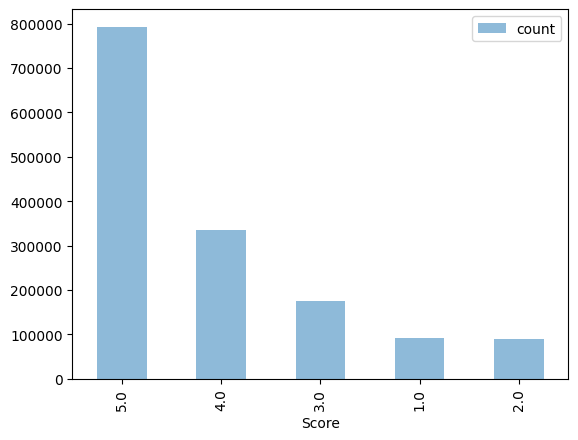


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [135]:
# trainingSet = pd.read_csv("./data/train.csv")
# testingSet = pd.read_csv("./data/test.csv")
trainingSet = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/train.csv')
testingSet = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/test.csv')

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [136]:
def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['Time'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['Time'].dt.year

    label_encoder = LabelEncoder()
    df['UserId'] = label_encoder.fit_transform(df['UserId'])
    # df['Month'] = df['Time'].dt.month
    # df['Day'] = df['Time'].dt.day
    # df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    # df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    # df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    # df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)

    df["Review Length"] = df["Text"].fillna("").apply(len)

    df["User Average Review Score"] = df.groupby('UserId')['Score'].transform('mean')

    sia = SentimentIntensityAnalyzer()
    if exists('/content/drive/MyDrive/CS506/midterm/data/Vader_train_summary.csv'):
      vader_df = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/Vader_train_summary.csv')
      df[['Vader_neg_summary', 'Vader_pos_summary', 'Vader_compound_summary']] = vader_df[['Vader_neg', 'Vader_pos', 'Vader_compound']]
    else:
      df[['Vader_neg_summary', 'Vader_neu_summary', 'Vader_pos_summary', 'Vader_compound_summary']] = df['Summary'].fillna('').apply(lambda x: pd.Series(sia.polarity_scores(x)))
      df[['Vader_neg_summary', 'Vader_neu_summary', 'Vader_pos_summary', 'Vader_compound_summary']].to_csv("/content/drive/MyDrive/CS506/midterm/data/Vader_train_summary.csv", index=False)

    if exists('/content/drive/MyDrive/CS506/midterm/data/Vader_train_text.csv'):
      vader_df = pd.read_csv('/content/drive/MyDrive/CS506/midterm/data/Vader_train_text.csv')
      df[['Vader_neg_text', 'Vader_pos_text', 'Vader_compound_text']] = vader_df[['Vader_neg_text', 'Vader_pos_text', 'Vader_compound_text']]
    else:
      df[['Vader_neg_text', 'Vader_neu_text', 'Vader_pos_text', 'Vader_compound_text']] = df['Text'].fillna('').apply(lambda x: pd.Series(sia.polarity_scores(x)))
      df[['Vader_neg_text', 'Vader_neu_text', 'Vader_pos_text', 'Vader_compound_text']].to_csv("/content/drive/MyDrive/CS506/midterm/data/Vader_train_text.csv", index=False)


    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['Summary'].fillna(''))
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    tfidf_df.fillna(0, inplace=True)

    svd_model = TruncatedSVD(n_components=250)

    svd_matrix = svd_model.fit_transform(tfidf_df)
    svd_df = pd.DataFrame(svd_matrix, columns=[f'SVD_Component_{i+1}' for i in range(svd_matrix.shape[1])])

    # pca_model = PCA(n_components=50)
    # pca_matrix = pca_model.fit_transform(tfidf_df)

    # pca_df = pd.DataFrame(pca_matrix, columns=[f'PCA_{i+1}' for i in range(pca_matrix.shape[1])])

    df_with_vectors = pd.concat([df.reset_index(drop=True), svd_df.reset_index(drop=True)], axis=1)

    return df_with_vectors

# Load the feature extracted files if they've already been generated
# if exists('./data/X_train.csv'):
#     X_train = pd.read_csv("./data/X_train.csv")
# if exists('./data/X_submission.csv'):
#     X_submission = pd.read_csv("./data/X_submission.csv")
if exists('/content/drive/MyDrive/CS506/midterm/data/X_train.csv'):
    X_train = pd.read_csv("/content/drive/MyDrive/CS506/midterm/data/X_train.csv")
if exists('/content/drive/MyDrive/CS506/midterm/data/X_submission.csv'):
    X_submission = pd.read_csv("/content/drive/MyDrive/CS506/midterm/data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    # X_submission.to_csv("./data/X_submission.csv", index=False)
    # X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [137]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [138]:
# features = ['Helpfulness', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Vader_score_summary', 'Vader_score_text']

# X_train_select = X_train[features]
# X_test_select = X_test[features]
# X_submission_select = X_submission[features]
columns_to_drop = ['ProductId', 'Time', 'UserId', 'Summary', 'Text', 'Id', 'HelpfulnessNumerator']
X_train_select = X_train.drop(columns=columns_to_drop)
X_test_select = X_test.drop(columns=columns_to_drop)
X_submission_select = X_submission.drop(columns=(columns_to_drop+['Score']))

In [139]:
display(X_train_select)

,HelpfulnessDenominator,Helpfulness,Year,Review Length,User Average Review Score,Vader_neg_summary,Vader_pos_summary,Vader_compound_summary,Vader_neg_text,Vader_pos_text,...,SVD_Component_241,SVD_Component_242,SVD_Component_243,SVD_Component_244,SVD_Component_245,SVD_Component_246,SVD_Component_247,SVD_Component_248,SVD_Component_249,SVD_Component_250
131283,13,1.000000,2005,3707,4.785714,0.0,0.381,0.5719,0.112,0.136,...,0.002025,0.000866,0.005218,-0.001859,-0.005889,0.002254,-0.000221,-0.002542,-0.005422,0.004637
1202017,1,1.000000,2012,720,3.833333,0.0,0.000,0.0000,0.095,0.115,...,-0.000213,0.001251,-0.000335,0.002775,0.000539,-0.000493,-0.000336,-0.000224,0.001865,-0.000455
511808,10,0.600000,2006,295,3.641509,0.0,0.000,0.0000,0.218,0.082,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
955172,4,0.750000,2013,2255,4.000000,0.0,0.000,0.0000,0.033,0.054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
735507,0,0.000000,2012,363,5.000000,0.0,0.000,0.0000,0.000,0.171,...,0.006885,-0.004821,0.001107,-0.000943,-0.000060,-0.001881,0.004559,0.000801,0.000802,0.000894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152315,0,0.000000,2001,447,4.111111,0.0,0.000,0.0000,0.097,0.161,...,0.042929,-0.010231,0.062713,0.117787,-0.099119,-0.056124,-0.104198,0.027658,0.146334,-0.039849
963395,2,0.000000,2008,358,3.359773,0.0,0.000,0.0000,0.109,0.260,...,0.099094,-0.004798,-0.023191,0.025576,0.040001,-0.043259,0.022107,-0.033628,0.042337,0.152233
117952,3,0.333333,2007,320,3.851852,0.0,1.000,0.4404,0.106,0.234,...,-0.001058,0.001123,-0.002565,-0.002138,-0.001613,0.001708,-0.002379,-0.000361,0.001002,-0.000449
1484405,28,0.892857,2007,3054,4.545455,0.0,0.339,0.6249,0.063,0.101,...,-0.015287,0.021330,-0.036973,-0.090057,0.024630,-0.006791,-0.005065,0.033648,-0.040061,-0.009453


In [140]:
display(X_submission_select)

,HelpfulnessDenominator,Helpfulness,Year,Review Length,User Average Review Score,Vader_neg_summary,Vader_pos_summary,Vader_compound_summary,Vader_neg_text,Vader_pos_text,...,SVD_Component_241,SVD_Component_242,SVD_Component_243,SVD_Component_244,SVD_Component_245,SVD_Component_246,SVD_Component_247,SVD_Component_248,SVD_Component_249,SVD_Component_250
0,0,0.00,2014,836,2.709677,NaN,NaN,NaN,0.069,0.236,...,-0.000294,0.000483,-0.000336,0.000434,-0.000080,0.000450,-0.000539,0.000654,0.000008,-0.000310
1,1,1.00,2013,106,4.277778,NaN,NaN,NaN,0.000,0.526,...,0.001791,-0.003746,0.005430,-0.002184,0.001098,-0.000582,0.002347,0.001273,0.000742,0.004646
2,0,0.00,2012,126,4.384615,NaN,NaN,NaN,0.241,0.174,...,0.001064,0.000629,-0.002238,-0.001418,0.000354,0.001477,-0.001615,0.000214,0.000064,-0.000203
3,5,1.00,2007,445,4.000000,NaN,NaN,NaN,0.014,0.248,...,-0.008014,0.014737,-0.001057,-0.008440,-0.000244,-0.006398,-0.003662,0.004229,-0.006918,0.010461
4,2,1.00,2014,551,4.888889,NaN,NaN,NaN,0.031,0.125,...,-0.044155,-0.045192,0.012075,0.017140,-0.012010,-0.028020,-0.034420,-0.044762,0.044891,0.025750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212187,0,0.00,2012,129,4.800000,NaN,NaN,NaN,0.000,0.283,...,-0.010794,-0.079814,-0.004568,-0.077398,-0.047560,0.040071,-0.008173,-0.057197,-0.091861,-0.055614
212188,0,0.00,2014,892,4.127443,NaN,NaN,NaN,0.055,0.100,...,0.001655,-0.000866,0.001283,-0.001801,0.001850,0.000935,-0.000020,0.002674,-0.000527,-0.001473
212189,0,0.00,2014,150,2.153846,NaN,NaN,NaN,0.000,0.481,...,-0.000847,0.000668,-0.003197,0.000444,0.001411,0.000248,-0.000548,0.001863,-0.000343,0.000437
212190,0,0.00,2008,4401,3.892857,NaN,NaN,NaN,0.073,0.127,...,-0.015365,0.018998,0.044268,0.000677,-0.025277,-0.002174,0.148164,-0.005960,0.038963,-0.058541


# Model Creation

In [141]:
# Learn the model
model = XGBClassifier(tree_method = "hist", device = "cuda").fit(X_train_select, Y_train.astype(int) - 1)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select) + 1

Accuracy on testing set =  0.6411201714888941


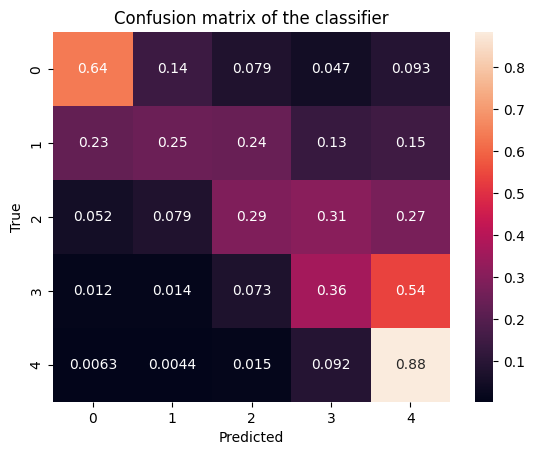

In [142]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [143]:
print("Accuracy on training set = ", accuracy_score(Y_train.astype(int) - 1, model.predict(X_train_select)))

Accuracy on training set =  0.6586810651657757


In [144]:
# Create the submission file
X_submission['Score'] = (model.predict(X_submission_select) + 1).astype('float64')
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [145]:
#from sklearn.model_selection import ParameterGrid

#param_grid = {
    #'n_estimators': [50, 100, 200],
    #'learning_rate': [0.1, 0.2, 0.3],
    #'max_depth': [4, 5, 6],
    #'min_child_weight': [1, 5, 10],
    #'gamma': [0, 0.1, 0.2],
    #'subsample': [0.7, 0.8, 1.0],
    #'colsample_bytree': [0.7, 0.8, 1.0],
    #'alpha': [0, 0.1],  # L1 regularization
    #'lambda': [1, 1.5]  # L2 regularization
#}

# n_estimators': 100,
#     'learning_rate': 0.3,
#     'max_depth': 6,
#     'subsample': 1.0,
#     'colsample_bytree': 1.0,
#So far the default works the best ._.

#grid = ParameterGrid(param_grid)

#for params in grid:
    #model = XGBClassifier(tree_method="hist", device="cuda", **params)
    #model.fit(X_train_select, Y_train.astype(int) - 1)

    # Make predictions on the test set
    #Y_test_predictions = model.predict(X_test_select) + 1

    # Calculate accuracy
    #accuracy = accuracy_score(Y_test, Y_test_predictions)
    #train_accuracy = accuracy_score(Y_train.astype(int) - 1, model.predict(X_train_select))

    # Print the parameters and accuracy
    #print(f"Params: {params} | Train Accuracy: {train_accuracy:.4f} | Test Accuracy: {accuracy:.4f}")

In [146]:
feature_importances = pd.DataFrame({
    'Feature': X_train_select.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

display(feature_importances)

,Feature,Importance
4,User Average Review Score,0.089866
7,Vader_compound_summary,0.033743
10,Vader_compound_text,0.028453
1,Helpfulness,0.024066
0,HelpfulnessDenominator,0.023381
...,...,...
70,SVD_Component_60,0.001336
123,SVD_Component_113,0.001334
204,SVD_Component_194,0.001296
188,SVD_Component_178,0.001236
